Deep Learning for time series prediction: Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) by Fernando Carazo and Joaquín Amat Rodrigo, available under the Attribution-NonCommercial-ShareAlike 4.0 International license at https://cienciadedatos.net/documentos/py41-forecasting-criptomoneda-bitcoin-machine-learning-python

In [ ]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.0/815.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import set_dark_theme

import skforecast
import sklearn
import lightgbm
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

import warnings
from skforecast.exceptions import LongTrainingWarning
warnings.filterwarnings("once")
warnings.simplefilter('ignore', category=LongTrainingWarning)

color = "\033[1m\033[38;5;208m"
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")


Versión skforecast: 0.16.0
Versión scikit-learn: 1.6.1
Version lightgbm: 4.5.0
Versión pandas: 2.2.2
Versión numpy: 2.0.2


In [ ]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/bitcoin.csv"
)
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.asfreq('D')
data

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


,open,high,low,close,volume,market cap
date,,,,,,
2013-04-28,128.000100,128.000100,128.000100,128.000100,0.000000e+00,1.418304e+09
2013-04-29,134.444400,135.980000,132.100000,134.210000,0.000000e+00,1.488338e+09
2013-04-30,134.444000,147.488000,134.000000,144.540000,0.000000e+00,1.549501e+09
2013-05-01,144.000000,146.930000,134.050000,139.000000,0.000000e+00,1.578685e+09
2013-05-02,139.000000,139.890000,107.720000,116.990000,0.000000e+00,1.422546e+09
...,...,...,...,...,...,...
2021-12-28,50787.263830,51950.912600,50459.263641,50650.171445,4.695844e+10,9.655866e+11
2021-12-29,50667.988338,50667.988338,47411.717237,47637.888400,5.939821e+10,9.241336e+11
2021-12-30,47547.865500,48112.021472,46272.662981,46408.302671,8.826973e+10,8.998872e+11


Los datos utilizados contienen el historial de precios de Bitcoin desde el 2013-04-28 al 2022-01-01. El dataset contiene las siguientes columnas:

**Date:** fecha del registro.

**Open:** precio de apertura, precio al que cotiza un activo, en este caso el Bitcoin, en el comienzo del día. Expresado en dólares estadounidenses (USD).

**High:** precio máximo del día, precio más alto alcanzado por el Bitcoin en ese día, (USD).

**Low:** precio mínimo del día, precio más bajo alcanzado por el Bitcoin en ese día, (USD).

**Close: **precio de cierre, precio al que cotiza el Bitcoin a la finalización del día, (USD).

**Volume:** volumen, suma de las operaciones reales realizadas durante el día, (USD).

**Market Cap:** capitalización de mercado, es el valor total de todas las acciones de una empresa o, en el caso de Bitcoin u otra criptomoneda, de todas las monedas que hay en circulación, (USD).

In [ ]:
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')


Número de filas con missing values: 0.0


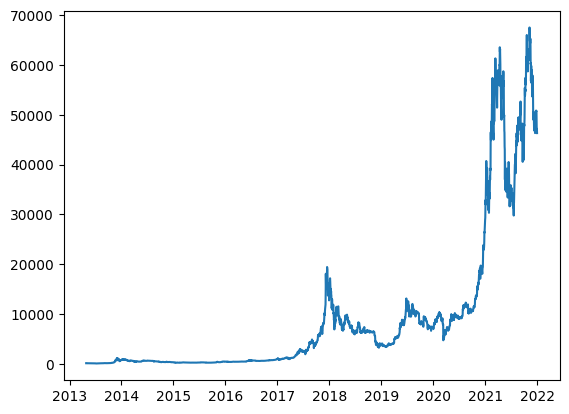

In [ ]:
plt.plot(data['close'])

## Halving del Bitcoin como variable exógena

El Halving es un evento programado y forma parte del diseño y funcionamiento de algunas criptomonedas. Los mineros se dedican a validar los bloques de transacciones de la red, en este caso Bitcoin, y, cada vez que lo logran, reciben como recompensa una cantidad de esa moneda digital. Esta cantidad es fija pero solo durante un tiempo.

En la blockchain de Bitcoin, cada vez que se añaden 210.000 bloques ocurre el cambio de recompensa. Este hecho, denominado como halving, se produce aproximadamente cada 4 años y reduce a la mitad las monedas que reciben los mineros.

En la historia de Bitcoin han existido 3 halvings. Cuando se lanzó la minería de Bitcoin, los mineros recibían 50 BTC al extraer con éxito un bloque. En 2012 esta recompensa se redujo a 25 BTC, en 2016 bajó a 12,5 BTC, y en 2020 a 6,25 BTC, después del tercer halving. Por lo general, cada halving ha tenido un impacto en el precio aunque no necesariamente ha sido en el corto plazo.

Se pretende utilizar los días restantes para el próximo halving y sus recompensas de minado como variables exógenas para predecir el precio de Bitcoin. Se calcula que el próximo halving ocurrirá aproximadamente en 2024 aunque se desconoce su fecha exacta. Para estimarla, se toman los bloques restantes a fecha de 2022-01-14 de la página web Coinmarketcap, 121.400, y se utiliza el promedio de los bloques de la red Bitcoin minados por día, 144 (tiempo de bloque promedio
≈
 10 minutos).

Nota: Al incorporar datos predichos como una variable exógena, se introduce, dado que se trata de predicciones, su error en el modelo de forecasting.

In [ ]:
btc_halving = {
    "halving": [0, 1, 2, 3, 4],
    "date": ["2009-01-03", "2012-11-28", "2016-07-09", "2020-05-11", np.nan],
    "reward": [50, 25, 12.5, 6.25, 3.125],
    "halving_block_number": [0, 210000, 420000, 630000, 840000],
}


In [ ]:
bloques_restantes = 121400
bloques_por_dia = 144
dias = bloques_restantes / bloques_por_dia
next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')
btc_halving['date'][-1] = next_halving

print(f'El próximo halving ocurrirá aproximadamente el: {next_halving}')

El próximo halving ocurrirá aproximadamente el: 2024-05-06


In [ ]:
data["reward"] = np.nan
data["countdown_halving"] = np.nan

for i in range(len(btc_halving["halving"]) - 1):

    # Fecha inicial y final de cada halving
    if btc_halving["date"][i] < data.index.min().strftime("%Y-%m-%d"):
        start_date = data.index.min().strftime("%Y-%m-%d")
    else:
        start_date = btc_halving["date"][i]

    end_date = btc_halving["date"][i + 1]
    mask = (data.index >= start_date) & (data.index < end_date)

    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, "reward"] = btc_halving["reward"][i]

    # Rellenar columna 'countdown_halving' con los días restantes
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)

    data.loc[mask, "countdown_halving"] = np.arange(time_to_next_halving.days)[::-1][
        : mask.sum()
    ]
print("Segundo halving:", btc_halving["date"][2])
display(data.loc["2016-07-08":"2016-07-09"])
print("")
print("Tercer halving:", btc_halving["date"][3])
display(data.loc["2020-05-10":"2020-05-11"])
print("")
print("Próximo halving:", btc_halving["date"][4])
data.tail(2)

Segundo halving: 2016-07-09


,open,high,low,close,volume,market cap,reward,countdown_halving
date,,,,,,,,
2016-07-08,677.331,682.432,611.834,639.667,1.892361e+08,1.015055e+10,25.0,0.0
2016-07-09,640.562,666.707,636.467,666.707,2.061508e+08,1.020561e+10,12.5,1401.0



Tercer halving: 2020-05-11


,open,high,low,close,volume,market cap,reward,countdown_halving
date,,,,,,,,
2020-05-10,9814.400817,9900.431521,9559.705894,9570.005988,3.675906e+10,1.786858e+11,12.50,0.0
2020-05-11,9554.216377,9554.216377,8388.959555,8745.152545,4.909643e+10,1.598261e+11,6.25,1455.0



Próximo halving: 2024-05-06


,open,high,low,close,volume,market cap,reward,countdown_halving
date,,,,,,,,
2021-12-31,46430.481224,47876.491839,46077.722276,47161.009200,1.229248e+11,8.907742e+11,6.25,856.0
2022-01-01,47139.359000,48505.999700,45712.566592,46304.949594,7.810027e+10,8.945653e+11,6.25,855.0


In [ ]:
candlestick = go.Candlestick(
    x=data.index,
    open=data.open,
    close=data.close,
    low=data.low,
    high=data.high,
)

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width=750,
    height=350,
    title=dict(text="<b>Chart Bitcoin/USD</b>", font=dict(size=20)),
    yaxis_title=dict(text="Precio (USD)", font=dict(size=15)),
    margin=dict(l=10, r=20, t=80, b=20),
    shapes=[
        dict(
            x0=btc_halving["date"][2],
            x1=btc_halving["date"][2],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
        dict(
            x0=btc_halving["date"][3],
            x1=btc_halving["date"][3],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
        dict(
            x0=btc_halving["date"][4],
            x1=btc_halving["date"][4],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
    ],
    annotations=[
        dict(
            x=btc_halving["date"][2],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Segundo halving",
        ),
        dict(
            x=btc_halving["date"][3],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Tercer halving",
        ),
        dict(
            x=btc_halving["date"][4],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Cuarto halving",
        ),
    ],
    xaxis_rangeslider_visible=False,
)

fig.show()

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



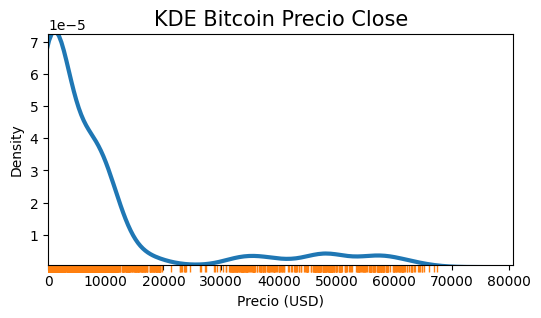

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.kdeplot(data=data, x="close", linewidth=3, ax=ax)
r = sns.rugplot(data=data, x="close", ax=ax, height=-0.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title("KDE Bitcoin Precio Close", fontsize=15)
p.set_xlabel("Precio (USD)");

En los datos de estudio se observa una distribución mayoritaria de precios por debajo de los 20.000 (USD). Esta etapa corresponde al periodo entre el año 2013 y septiembre de 2020. En cambio, desde 2021, el precio se ha situado en la zona de los 35.000 - 67.500 (USD).

Tratar de modelar una serie temporal con una distribución muy asimétrica y distintos órdenes de magnitud a lo largo del tiempo puede ser complicado. Una estrategia, para tratar de minimizar estos problemas, es modelar los cambios (deltas) en lugar de los valores directos. Esto se podría simplificar aún más llevándolo al punto de indicar únicamente si el precio aumenta o disminuye respecto al día anterior.



In [ ]:
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:

    year_open = data.loc[data.index.year == year, "open"].iloc[0]
    year_close = data.loc[data.index.year == year, "close"].iloc[-1]
    year_low = data.loc[data.index.year == year, "low"].min()
    year_high = data.loc[data.index.year == year, "high"].max()

    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high])

df_plot = df_plot.T
df_plot = df_plot.set_axis(["open", "close", "low", "high"], axis=1)

# Se calcula el % de cambio entre el open y el close del año
# ==============================================================================
df_plot["year_change"] = 100 * (df_plot["close"] - df_plot["open"]) / df_plot["open"]
df_plot.head(3)

,open,close,low,high,year_change
2013,128.0001,756.130,65.526,1156.140,490.726101
2014,760.3200,310.610,289.296,1017.120,-59.147464
2015,310.7370,426.371,171.510,495.562,37.212820


In [ ]:
annotations_list = []
max_high = df_plot["high"].max()

for year in years:

    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x = pd.to_datetime(df_aux.index[0], format="%Y")
    loc_y = df_aux["high"].values[0] / max_high + 0.05
    text = "{:.1f}%".format(df_aux["year_change"].values[0])

    annotation = dict(
        x=loc_x,
        y=loc_y,
        xref="x",
        yref="paper",
        showarrow=False,
        xanchor="center",
        text=text,
    )

    annotations_list.append(annotation)

# Gráfico de velas japonesas anual interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
    x=pd.to_datetime(df_plot.index, format="%Y"),
    open=df_plot.open,
    close=df_plot.close,
    low=df_plot.low,
    high=df_plot.high,
)

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width=750,
    height=350,
    title=dict(text="<b>Chart Bitcoin/USD por año</b>", font=dict(size=20)),
    yaxis_title=dict(text="Precio (USD)", font=dict(size=13)),
    margin=dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible=False,
    annotations=annotations_list,
)

fig.show()

In [ ]:
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for mes in range(12):

        start_date = pd.to_datetime(f"{year}-{mes+1}-01", format="%Y-%m-%d")
        end_date = start_date + pd.offsets.MonthBegin()
        mask = (data.index >= start_date) & (data.index < end_date)

        if not data.loc[mask, :].empty:

            month_open = data.loc[mask, "open"].iloc[0]
            month_close = data.loc[mask, "close"].iloc[-1]
            month_low = data.loc[mask, "low"].min()
            month_high = data.loc[mask, "high"].max()

            serie = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f"{str(mes+1).zfill(2)}-{year}"])

            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(["open", "close", "low", "high"], axis=1)
#

In [ ]:
df_plot["mes"] = pd.to_datetime(df_plot.index, format="%m-%Y").month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values("mes"), x="mes", y="close")

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby("mes")["close"].median()).reset_index()
fig2 = px.line(df_median, x="mes", y="close", markers=True)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width=650,
    height=350,
    title=dict(text="<b>BTC Precio por mes</b>", font=dict(size=20)),
    yaxis_title=dict(text="Precio (USD)", font=dict(size=13)),
    xaxis=dict(tickmode="linear"),
    xaxis_title=dict(text="mes", font=dict(size=13)),
    margin=dict(l=0, r=20, t=55, b=20),
)

fig.show()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen 

In [ ]:
data["dia_mes"] = pd.Series(data.index).dt.day.values

# fig 1 boxplot de los días del mes
fig1 = px.box(data.sort_values("dia_mes"), x="dia_mes", y="close")

# fig 2 line con datos de la mediana de los días del mes
df_median = pd.DataFrame(data.groupby("dia_mes")["close"].median()).reset_index()
fig2 = px.line(df_median, x="dia_mes", y="close", markers=True)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width=750,
    height=350,
    title=dict(text="<b>BTC Precio por día del mes</b>", font=dict(size=20)),
    yaxis_title=dict(text="Precio (USD)", font=dict(size=13)),
    xaxis=dict(tickmode="linear", tickangle=0, range=[0.5, 31.5]),
    xaxis_title=dict(text="día", font=dict(size=13)),
    margin=dict(l=0, r=20, t=55, b=20),
)

fig.show()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [ ]:
data["dia_semana"] = data.index.day_of_week + 1

# fig 1 boxplot de los días de la semana
fig1 = px.box(
    data.sort_values("dia_semana"),
    x="dia_semana",
    y="close"
)

# fig 2 line con datos de la mediana los días de la semana
df_median = pd.DataFrame(data.groupby("dia_semana")["close"].median()).reset_index()
fig2 = px.line(
    df_median,
    x="dia_semana",
    y="close",
    markers=True
)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width=600,
    height=300,
    title=dict(text="<b>BTC Precio por día de la semana</b>", font=dict(size=20)),
    yaxis_title=dict(text="Precio (USD)", font=dict(size=13)),
    xaxis=dict(tickmode="linear"),
    xaxis_title=dict(text="día de la semana", font=dict(size=13)),
    margin=dict(l=0, r=20, t=55, b=20),
)

fig.show()

Por lo general, una serie temporal con patrón autoregresivo presenta un carácter repetitivo a lo largo del tiempo (tendencia, estacionalidad, factores cíclicos...). Respecto al Bitcoin, se puede apreciar una cierta estacionalidad anual al final y principio del año con variaciones más grandes en el precio. En cambio, no aparece ningún tipo de estacionalidad en los intervalos mensual y semanal, se tienen distribuciones muy similares.



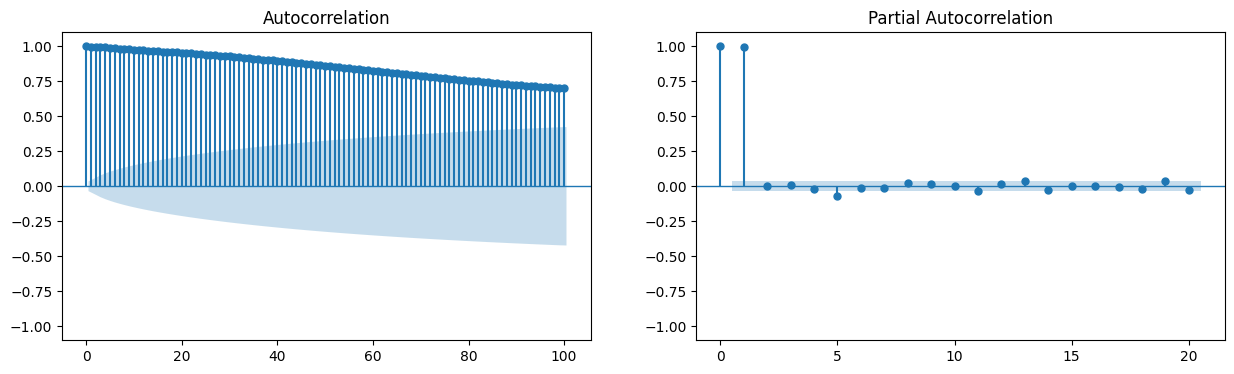

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=20, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

A la hora de generar un modelo predictivo es conveniente identificar un modelo base, o baseline, sobre el que ir comparando cada una de las iteraciones o modelos propuestos. En el caso de las finanzas, acorde a la teoría del paseo aleatorio o Random Walk, los precios de mercado se comportan de manera aleatoria y no dependiente de su serie temporal. De esta manera, la mejor estimación para el valor $t_{n+1}$ es el valor
$t_n$ más un cambio impredecible.

Aunque se dispone de una serie temporal amplia, esta presenta periodos con precios muy diferenciados como se ha podido determinar en la exploración gráfica. Se opta por utilizar solo los dos últimos años de datos.



In [ ]:
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}  (n={len(data.loc[inicio_train:fin_train])})")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}  (n={len(data.loc[fin_train:])})")


Serie temporal completa : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00  (n=3171)
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Fechas test             : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00  (n=185)


In [ ]:
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Error de test
# ==============================================================================
y_true = df_rw.loc[fin_train:, 'close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].head(4))

Error de test: 1260.3677521425916


,close,pred_close
date,,
2021-07-01,35060.428966,35840.386468
2021-07-02,33628.670000,35060.428966
2021-07-03,33846.007087,33628.670000
2021-07-04,34698.303129,33846.007087


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



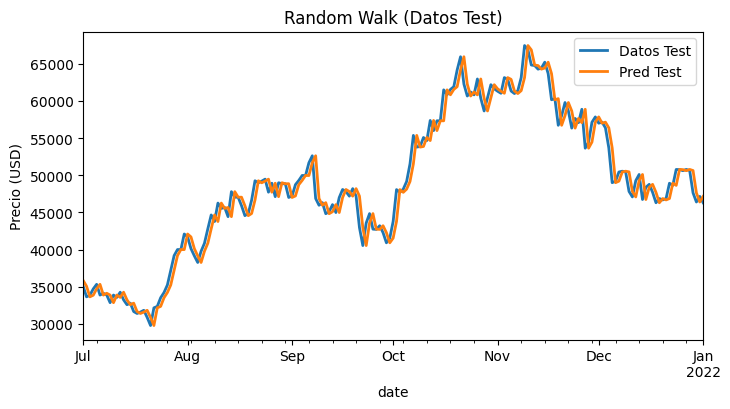

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
df_rw.loc[fin_train:, "close"].plot(ax=ax, linewidth=2, label="Datos Test")
df_rw.loc[fin_train:, "pred_close"].plot(ax=ax, linewidth=2, label="Pred Test")
ax.set_title("Random Walk (Datos Test)")
ax.set_ylabel("Precio (USD)")
ax.legend()

In [ ]:
df_errores = pd.DataFrame({
        "modelo": "Base - Random Walk",
        "lags": 1,
        "error_test": metrica,
        "variables_exog": False,
    },
    index=[0],
)
df_errores


,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,1260.367752,False


Para intentar modelar el precio de Bitcoin se utiliza un Forecaster Autorregresivo (ForecasterRecursive) con un regresor LightGBM, una implementación del algoritmo de Gradient Boosting desarrollada por Microsoft que suele conseguir excelentes resultados.

Los estudios anteriores muestran una ausencia de autocorrelación más allá del primer lag. Una forma de verificarlo es entrenar varios modelos con una cantidad creciente de lags y comprobar si el error no se reduce. Esta aproximación se puede realizar mediante backtesting utilizando steps = 1 (predecir únicamente el siguiente valor de la serie, $t_{n+1}$) para reproducir la metodología del modelo Random Walk.



In [ ]:
lags = [1, 7, 30]
metricas = []
predicciones_list = []

for lag in lags:

    # Crear forecaster
    forecaster = ForecasterRecursive(
                     regressor     = LGBMRegressor(random_state=123, verbose=-1),
                     lags          = lag,
                     transformer_y = None
                 )

    # Backtest test data 1 step
    cv = TimeSeriesFold(
            steps              = 1,
            initial_train_size = len(data.loc[inicio_train:fin_train,]),
            fixed_train_size   = True,
            refit              = True,
         )
    metrica, predicciones = backtesting_forecaster(
                                forecaster    = forecaster,
                                y             = data.loc[inicio_train:, 'close'],
                                cv            = cv,
                                metric        = 'mean_absolute_error',
                                verbose       = False,
                                show_progress = True,
                            )

    metricas.append(metrica.at[0, 'mean_absolute_error'])
    predicciones_list.append(predicciones)


  0%|          | 0/185 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

  0%|          | 0/185 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

  0%|          | 0/185 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

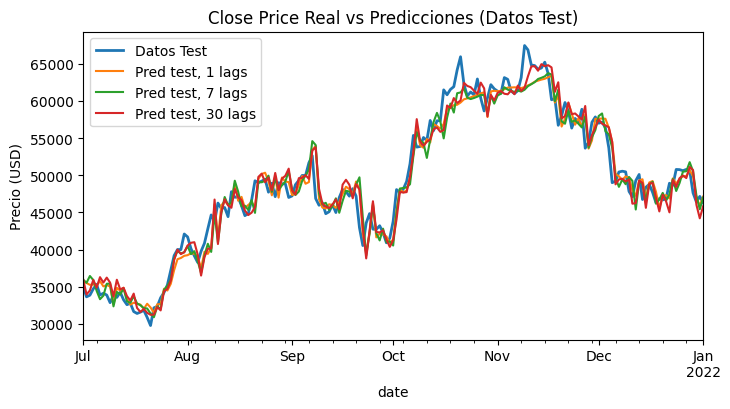

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
data.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones test para diferentes lags
for predicciones, lag in zip(predicciones_list, lags):
    predicciones = predicciones.rename(columns={'pred': f'Pred test, {lag} lags'})
    predicciones.plot(ax=ax)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [ ]:
modelo = 'LGBMRegressor'
df_errores = pd.concat([
                df_errores,
                pd.DataFrame({
                    'modelo': modelo,
                    'lags': lags,
                    'error_test': metricas,
                    'variables_exog': False
                })
             ]).reset_index(drop=True)
df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,1260.367752,False
1,LGBMRegressor,1,1527.440787,False
2,LGBMRegressor,7,1546.268058,False
3,LGBMRegressor,30,1561.058347,False


Los errores de test (los cuales reflejan cómo de bien generaliza cada modelo) demuestran que ninguno de los modelos mejora el baseline a pesar de que se incorpore más información del pasado (número de lags). En vista de los resultados, se intentan otras alternativas como es la incorporación de variables exógenas a la serie.



Además de utilizar predictores autorregresivos generados a partir del pasado de la propia variable respuesta, es posible añadir otras variables exógenas, cuyo valor a futuro se conoce, con el fin de mejorar la predicción. Algunos ejemplos típicos son:

Festivos (local, nacional...)

Mes del año

Día de la semana

Hora del día

Para este caso, se decide utilizar las variables resultantes del apartado sobre el halving del Bitcoin y, tras el estudio de la estacionalidad, el mes del año.

Nota: Las variables reward y mes, aunque codificadas como números, son categóricas, por lo que conviene cambiar el tipo con el que están almacenadas. Dado que estas variables no tienen muchos niveles se recurre a la estrategia de One Hot Encoding para incorporarlas al modelo.



In [ ]:
data['mes'] = data.index.month
data = pd.get_dummies(data, columns=['reward', 'mes'], dtype=int)
data.head(2)

,open,high,low,close,volume,market cap,countdown_halving,dia_mes,dia_semana,reward_6.25,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,128.0001,128.0001,128.0001,128.0001,0.0,1.418304e+09,1167.0,28,7,0,...,0,1,0,0,0,0,0,0,0,0
2013-04-29,134.4444,135.9800,132.1000,134.2100,0.0,1.488338e+09,1166.0,29,1,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
exog

['reward_6.25',
 'reward_12.5',
 'reward_25.0',
 'mes_1',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'mes_10',
 'mes_11',
 'mes_12',
 'countdown_halving']

In [ ]:
forecaster = ForecasterRecursive(
                 regressor        = LGBMRegressor(random_state=123, verbose=-1),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )

# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = data.loc[inicio_train:, 'close'],
                            exog          = data.loc[inicio_train:, exog],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            verbose       = False,
                            show_progress = True
                        )

  0%|          | 0/185 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

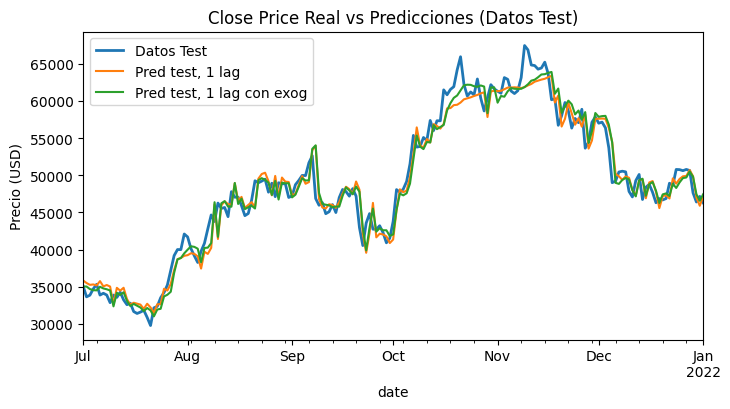

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
data.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones 1 lag sin variables exógenas
predicciones_no_exog = predicciones_list[0].rename(columns={'pred': f'Pred test, 1 lag'})
predicciones_no_exog.plot(ax=ax)

# Plot predicciones 1 lag con variables exógenas
predicciones_exog = predicciones.rename(columns={'pred': f'Pred test, 1 lag con exog'})
predicciones_exog.plot(ax=ax)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [ ]:
modelo = 'LGBMRegressor'
df_errores = pd.concat([
                df_errores,
                pd.DataFrame({
                    'modelo': modelo,
                    'lags': lags,
                    'error_test': metricas,
                    'variables_exog': True
                })
             ]).reset_index(drop=True)
df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,1260.367752,False
1,LGBMRegressor,1,1527.440787,False
4,LGBMRegressor,1,1527.440787,True
2,LGBMRegressor,7,1546.268058,False
5,LGBMRegressor,7,1546.268058,True
3,LGBMRegressor,30,1561.058347,False
6,LGBMRegressor,30,1561.058347,True


Aun incorporando variables exógenas, el modelo no consigue mejorar el baseline (random walk).



Como se ha demostrado en este documento, el precio de Bitcoin no sigue un patrón autorregresivo, la mejor estimación para el valor es $t_{n+1}$  más un cambio impredecible. La identificación temprana de la ausencia de esta correlación mediante análisis descriptivo evita esfuerzos de modelado innecesarios.

Cuando se dispone de una serie temporal con ausencia de autocorrelación se deben buscar variables exógenas capaces de ayudar en el problema. Por ejemplo, si se intentase predecir el precio de Bitcoin a corto plazo (horas) podrían emplearse como variables exógenas el sentimiento del mercado mediante el análisis de tweets, impacto de los denominados key opinion leaders, análisis de noticias más relevantes, etc.

# Modelo para la varianza

In [ ]:
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [ ]:
data["log_rtn"] = np.log(data["close"]/data["close"].shift(1))
df = data[["close", "log_rtn"]].dropna()
df

,close,log_rtn
date,,
2013-04-30,144.540000,0.074151
2013-05-01,139.000000,-0.039082
2013-05-02,116.990000,-0.172385
2013-05-03,105.210000,-0.106130
2013-05-04,97.750000,-0.073545
...,...,...
2021-12-28,50650.171445,-0.002953
2021-12-29,47637.888400,-0.061314
2021-12-30,46408.302671,-0.026150


In [ ]:
r_range = np.linspace(min(df["log_rtn"]),
                      max(df["log_rtn"]),
                      num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

<ipython-input-48-c1eff2508a5e>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




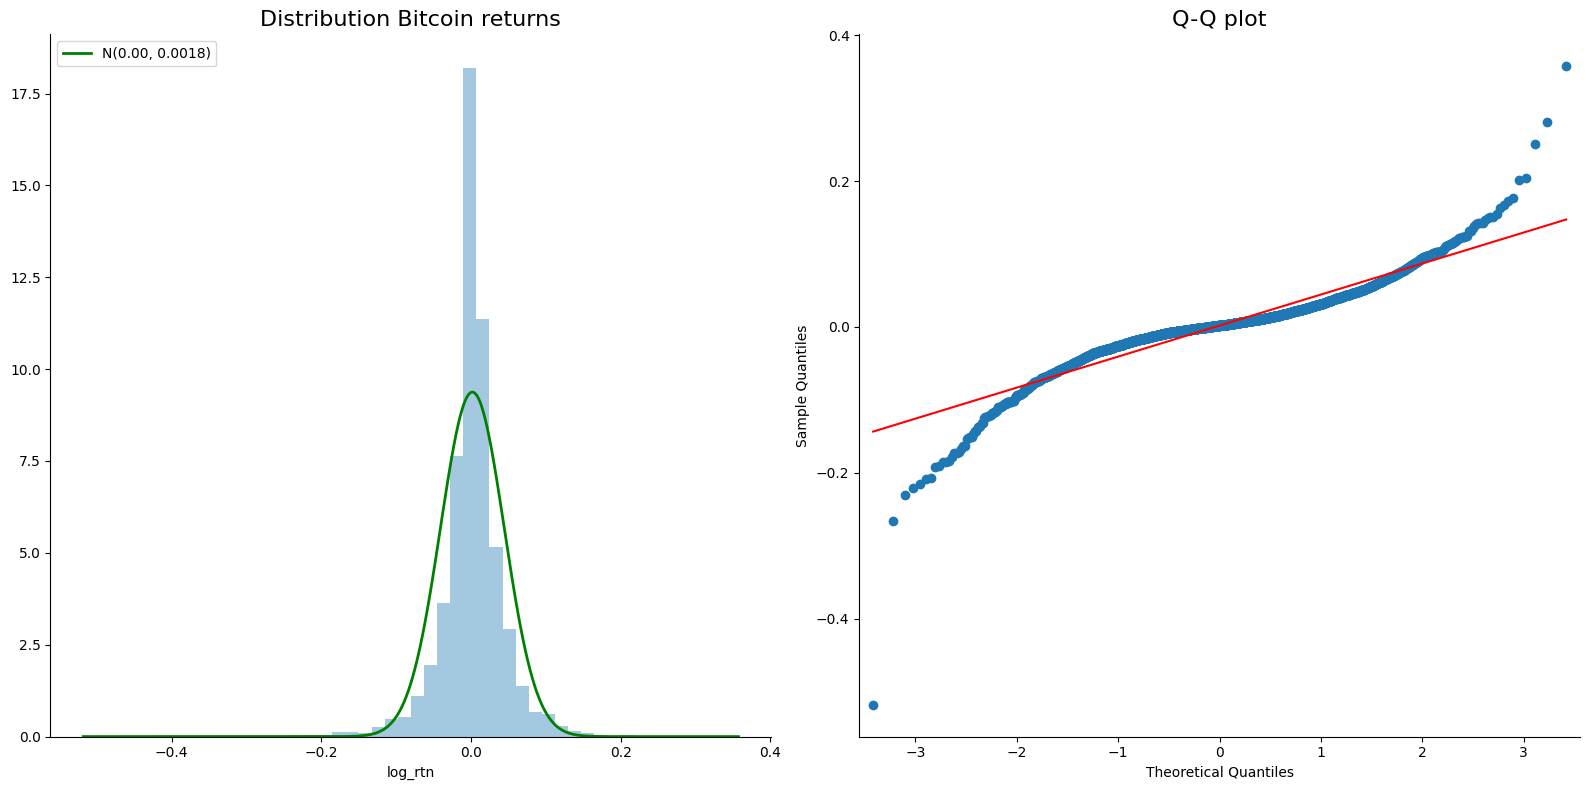

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False,
             norm_hist=True, ax=ax[0])
ax[0].set_title("Distribution Bitcoin returns",
                fontsize=16)
ax[0].plot(r_range, norm_pdf, "g", lw=2,
           label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left");

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize = 16)

sns.despine()
plt.tight_layout()

In [ ]:
jb_test = scs.jarque_bera(df["log_rtn"].values)

print("---------- Descriptive Statistics ----------")
print("Range of dates:", min(df.index.date), "-", max(df.index.date))
print("Number of observations:", df.shape[0])
print(f"Mean: {df.log_rtn.mean():.4f}")
print(f"Median: {df.log_rtn.median():.4f}")
print(f"Min: {df.log_rtn.min():.4f}")
print(f"Max: {df.log_rtn.max():.4f}")
print(f"Standard Deviation: {df.log_rtn.std():.4f}")
print(f"Skewness: {df.log_rtn.skew():.4f}")
print(f"Kurtosis: {df.log_rtn.kurtosis():.4f}")
print(f"Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}")

---------- Descriptive Statistics ----------
Range of dates: 2013-04-30 - 2022-01-01
Number of observations: 3169
Mean: 0.0018
Median: 0.0019
Min: -0.5181
Max: 0.3575
Standard Deviation: 0.0426
Skewness: -0.6761
Kurtosis: 13.1813
Jarque-Bera statistic: 23103.98 with p-value: 0.00


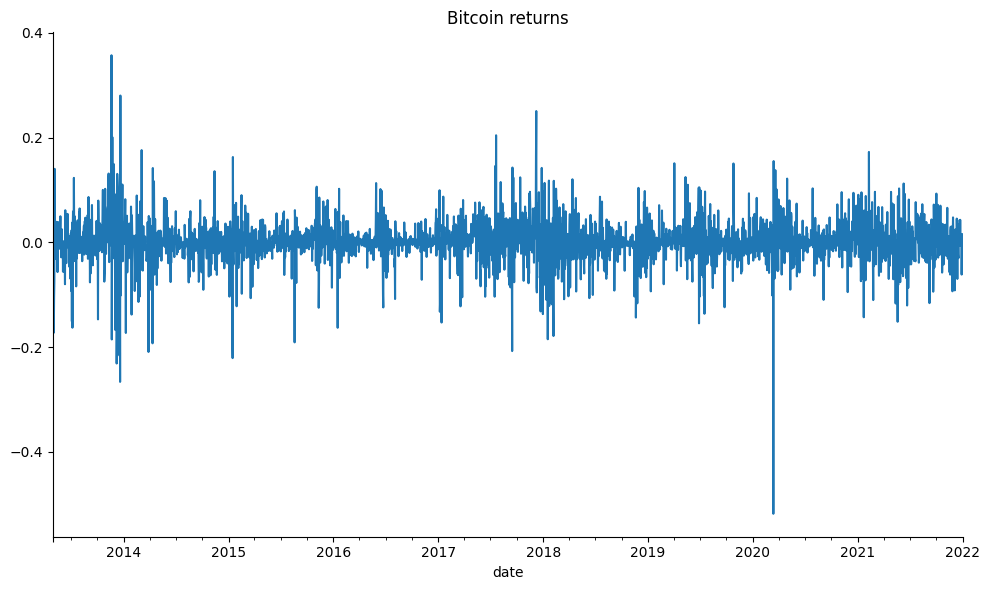

In [ ]:
(
    df["log_rtn"]
    .plot(title="Bitcoin returns", figsize=(10, 6))
)

sns.despine()
plt.tight_layout()

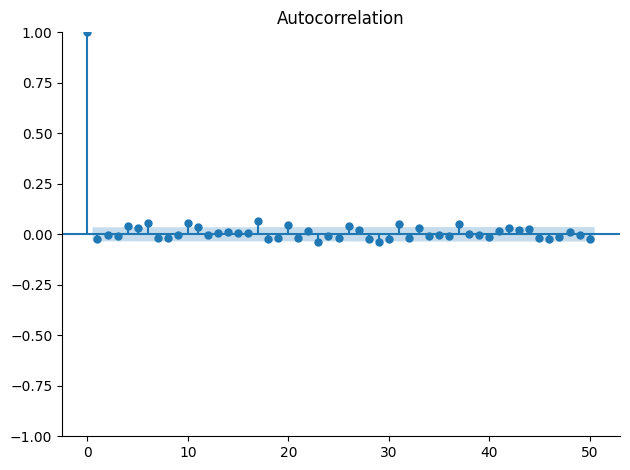

In [ ]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
acf = smt.graphics.plot_acf(df["log_rtn"],
                            lags=N_LAGS,
                            alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()

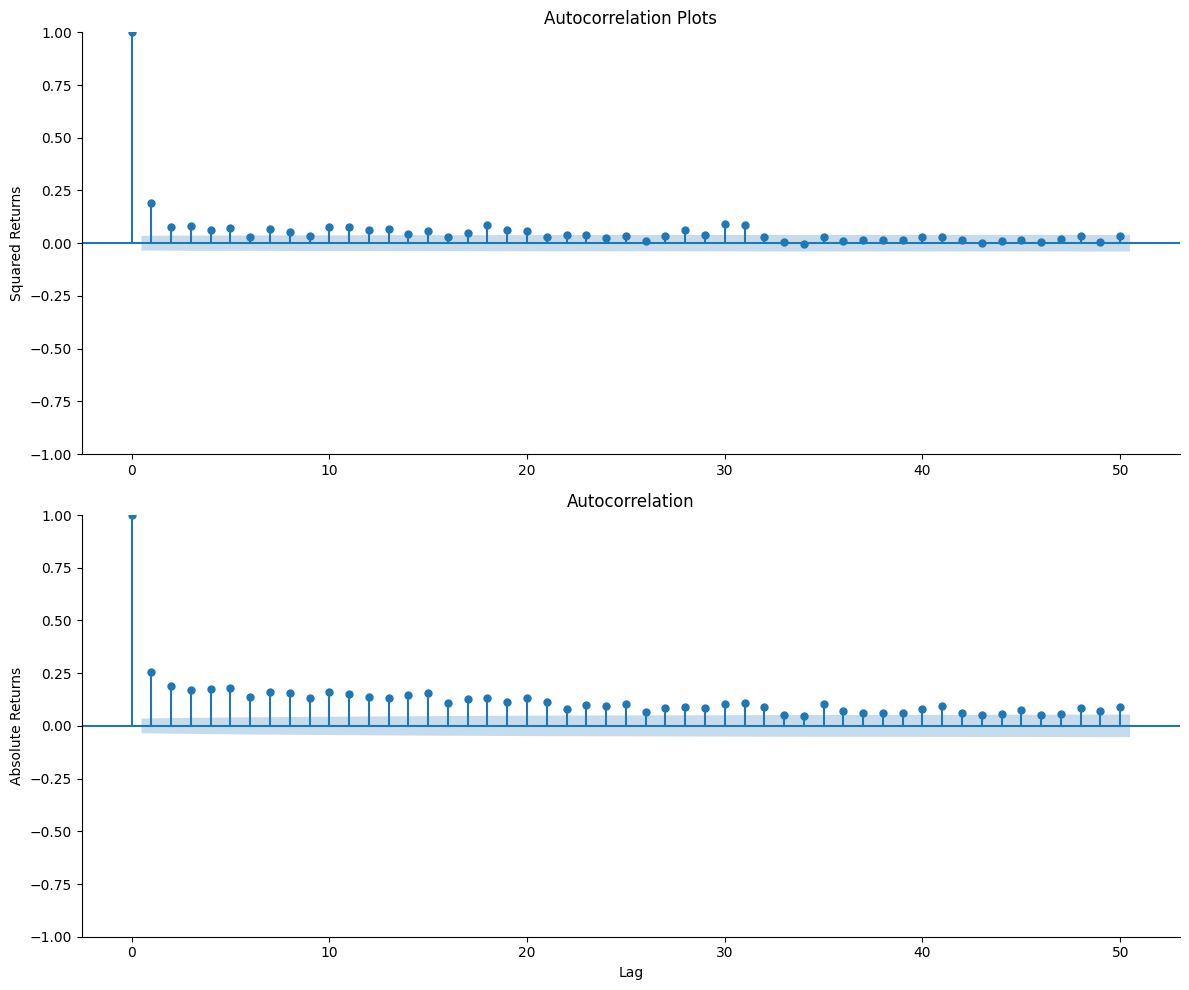

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots",
          ylabel="Squared Returns")

smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns",
          xlabel="Lag")

sns.despine()
plt.tight_layout()
plt.show()

Si bien no esperamos autocorrelación en la serie de rendimientos, se ha demostrado empíricamente que podemos observar una autocorrelación pequeña y lentamente decreciente (también conocida como persistencia) en funciones no lineales simples de los rendimientos, como los rendimientos absolutos o al cuadrado. Esta observación está relacionada con el fenómeno que ya hemos investigado, es decir, la agrupación de volatilidad.
La función de autocorrelación de los rendimientos al cuadrado es una medida común de la agrupación de volatilidad. También se conoce como efecto ARCH, ya que es un componente clave de los modelos (G)ARCH. Sin embargo, debemos tener en cuenta que esta propiedad es independiente del modelo y no está exclusivamente relacionada con los modelos de la clase GARCH."
En este contexto, la autocorrelación en los rendimientos al cuadrado es un indicador de la presencia de agrupación de volatilidad, lo que significa que los períodos de alta volatilidad tienden a seguirse de otros períodos de alta volatilidad, y viceversa. Esto es importante en la modelización financiera, ya que puede ayudar a predecir y gestionar el riesgo asociado con los activos financieros.

In [ ]:
df["rolling_std_7"] = df[["log_rtn"]].rolling(window=21).std()

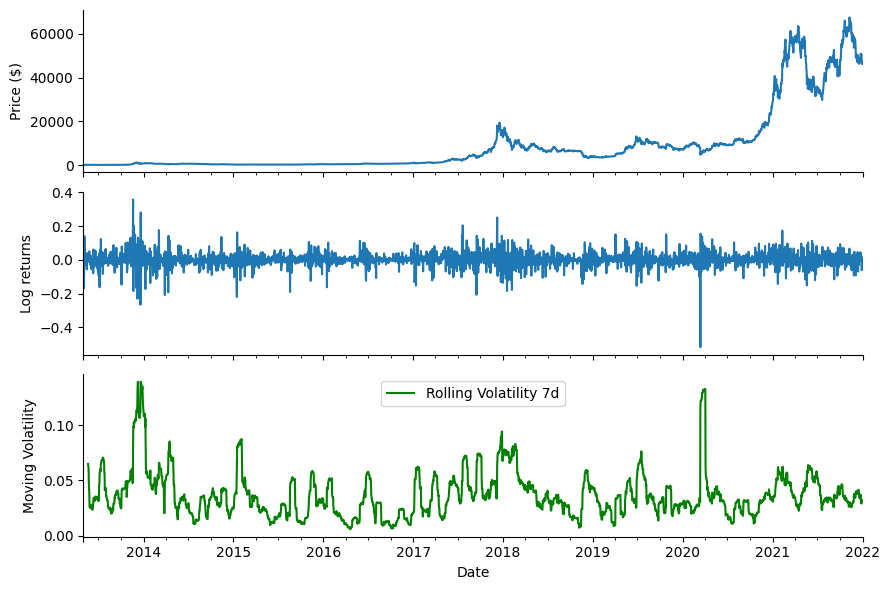

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(9, 6),
                       sharex=True)

df["close"].plot(ax=ax[0])
ax[0].set(title="",
          ylabel="Price ($)")

df["log_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")

df["rolling_std_7"].plot(ax=ax[2], color="g",
                           label="Rolling Volatility 7d")
ax[2].set(ylabel="Moving Volatility",
          xlabel="Date")
ax[2].legend()

sns.despine()
plt.tight_layout()

# Modelación de la volatilidad

Además de modelos de volatilidad como ARCH, GARCH, EGARCH y otros, se pueden usar técnicas de ML para modelar y predecir la volatilidad.

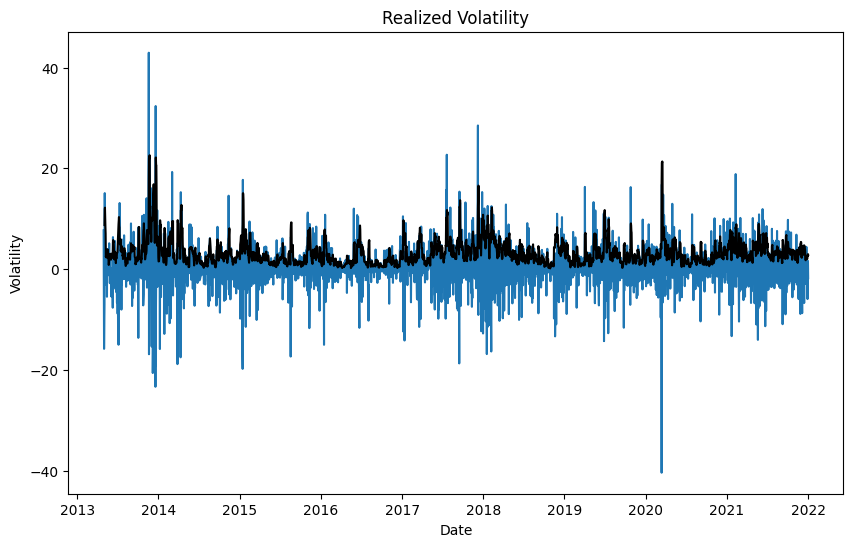

In [ ]:
log_returns = 100 * (data.pct_change()[1:]['close'])
realized_vol = ret.rolling(5).std()

plt.figure(figsize=(10, 6))
plt.plot(log_returns)
plt.plot(realized_vol.index,realized_vol,color='black')

plt.title('Realized Volatility')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [ ]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [ ]:
returns_sq = log_returns ** 2
returns_sq = returns_sq.reset_index()
del returns_sq['date']

In [ ]:
X = pd.concat([realized_vol, returns_sq], axis=1, ignore_index=True)
X = X[3:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [ ]:
X

,0,1
0,NaN,101.389527
1,8.755230,50.276335
2,11.728992,227.693435
3,12.196657,9.187635
4,9.966435,9.700019
...,...,...
3161,2.021905,0.086964
3162,2.640085,35.369565
3163,2.595059,6.662123
3164,2.976360,2.630631


In [ ]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [ ]:
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [ ]:
X.dropna(inplace=True)

In [ ]:
X

,0,1
1,8.755230,50.276335
2,11.728992,227.693435
3,12.196657,9.187635
4,9.966435,9.700019
5,8.470356,0.507482
...,...,...
3161,2.021905,0.086964
3162,2.640085,35.369565
3163,2.595059,6.662123
3164,2.976360,2.630631


In [ ]:
realized_vol

,close
0,8.755230
1,11.728992
2,12.196657
3,9.966435
4,8.470356
...,...
3160,2.021905
3161,2.640085
3162,2.595059
3163,2.976360


In [ ]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [ ]:
n=252
para_grid = {'gamma': sp_rand(),
                      'C': sp_rand(),
                      'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [ ]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [ ]:
from sklearn.metrics import mean_squared_error as mse

rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.002261


In [ ]:
realized_vol.index = ret.iloc[4:].index

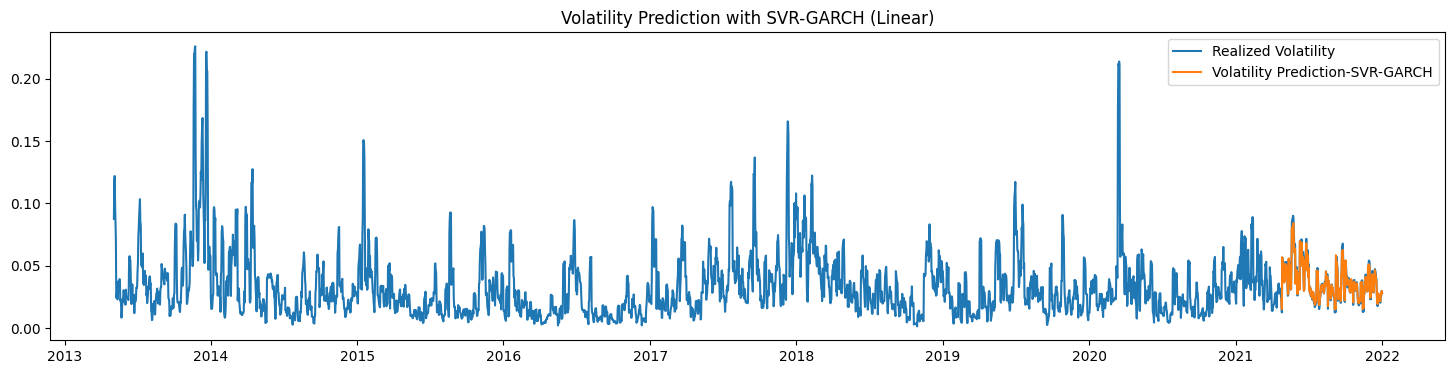

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                        'max_iter': [500, 1000],
                        'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [ ]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

In [ ]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                               NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of NN is 0.003121


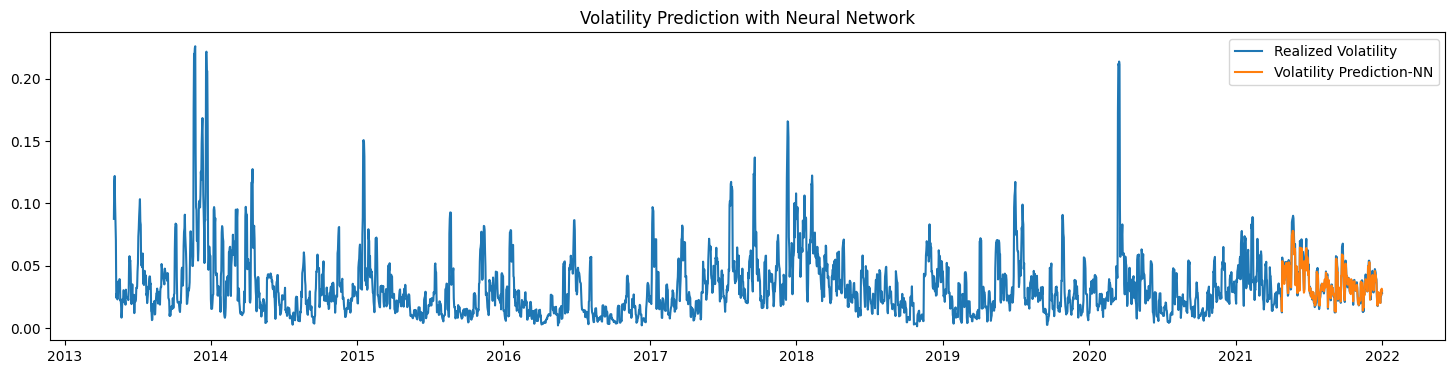

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
DL_RMSE_1:0.003330
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
DL_RMSE_2:0.003285
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
DL_RMSE_3:0.002792
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
DL_RMSE_4:0.005673


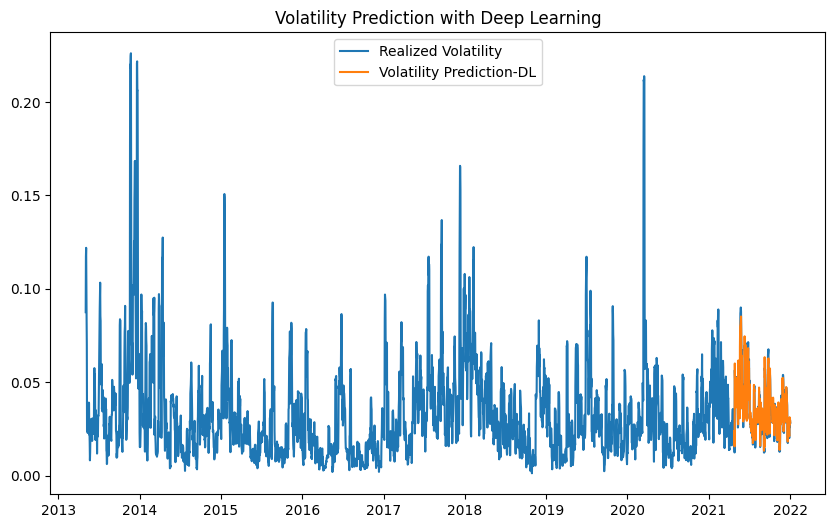

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
             [layers.Dense(256, activation="relu"),
              layers.Dense(128, activation="relu"),
              layers.Dense(1, activation="linear"),])

model.compile(loss='mse', optimizer='rmsprop')

epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
  model.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1,),batch_size=k, epochs=j, verbose=False)
  DL_predict = model.predict(np.asarray(X.iloc[-n:]))
  DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,DL_predict.flatten() / 100)))
  DL_pred.append(DL_predict)
  print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()